In [36]:
# Install and load the necessary libraries
library(readr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Define the URL for the Census Income dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Define column names
column_names <- c("age", "workclass", "fnlwgt", "education", "education.num", 
                  "marital.status", "occupation", "relationship", "race", 
                  "sex", "capital_gain", "capital_loss", "hours_per_week", 
                  "native_country", "income")

# Read the Census Income dataset into a dataframe
census_income <- read.csv(url, header = FALSE, col.names = column_names)

# Display the first few rows of the dataframe
head(census_income)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


Creating test and train splits

In [37]:
# Create test and train splits
adult_split = initial_split(adult_df, prop = 0.75, strata = income)
adult_training = training(adult_split)
adult_testing = testing(adult_split)

Create summary tables

In [38]:
# Create a table summarizing the number of observations for each class in income, sex, race
summary_table <- adult_training |>
  group_by(income, sex, race) |>
  summarize(count = n())

# Display the summary table, print them for better readability
print("Summary Table:")
print(summary_table)

# Produce means for age, education_num, hours_per_week (vars we will likely use)
means_table <- adult_training |>
    group_by(income, sex, race) |>
    summarize(
        mean_age = mean(age),
        mean_education_num = mean(education_num),
        mean_hours_per_week = mean(hrs_per_week)
      )

print("Means Table:")
print(means_table)

# Find the number of rows with missing values
missing_rows_training <- adult_training %>%
  summarise_all(~sum(is.na(.)))

# Display the number of rows with missing values
print("Number of Rows with Missing Values:")
print(sum(missing_rows_training))

`summarise()` has grouped output by 'income', 'sex'. You can override using the
`.groups` argument.


[1] "Summary Table:"
# A tibble: 20 × 4
# Groups:   income, sex [4]
   income   sex       race                  count
   <chr>    <chr>     <chr>                 <int>
 1 " <=50K" " Female" " Amer-Indian-Eskimo"    76
 2 " <=50K" " Female" " Asian-Pac-Islander"   239
 3 " <=50K" " Female" " Black"               1103
 4 " <=50K" " Female" " Other"                 82
 5 " <=50K" " Female" " White"               5643
 6 " <=50K" " Male"   " Amer-Indian-Eskimo"   128
 7 " <=50K" " Male"   " Asian-Pac-Islander"   344
 8 " <=50K" " Male"   " Black"                985
 9 " <=50K" " Male"   " Other"                109
10 " <=50K" " Male"   " White"               9831
11 " >50K"  " Female" " Amer-Indian-Eskimo"     7
12 " >50K"  " Female" " Asian-Pac-Islander"    36
13 " >50K"  " Female" " Black"                 71
14 " >50K"  " Female" " Other"                  5
15 " >50K"  " Female" " White"                774
16 " >50K"  " Male"   " Amer-Indian-Eskimo"    17
17 " >50K"  " Male"   " Asian-Pa

`summarise()` has grouped output by 'income', 'sex'. You can override using the
`.groups` argument.


[1] "Means Table:"
# A tibble: 20 × 6
# Groups:   income, sex [4]
   income   sex       race       mean_age mean_education_num mean_hours_per_week
   <chr>    <chr>     <chr>         <dbl>              <dbl>               <dbl>
 1 " <=50K" " Female" " Amer-In…     37.7               9.47                35.9
 2 " <=50K" " Female" " Asian-P…     33.9              10.2                 36.7
 3 " <=50K" " Female" " Black"       37.4               9.40                36.3
 4 " <=50K" " Female" " Other"       31.7               8.83                36.2
 5 " <=50K" " Female" " White"       36.0               9.91                35.8
 6 " <=50K" " Male"   " Amer-In…     35.7               8.88                41.9
 7 " <=50K" " Male"   " Asian-P…     36.4              10.8                 39.3
 8 " <=50K" " Male"   " Black"       36.4               9.11                39.0
 9 " <=50K" " Male"   " Other"       33.8               8.51                41.9
10 " <=50K" " Male"   " White"       37.3  

Create bar plots

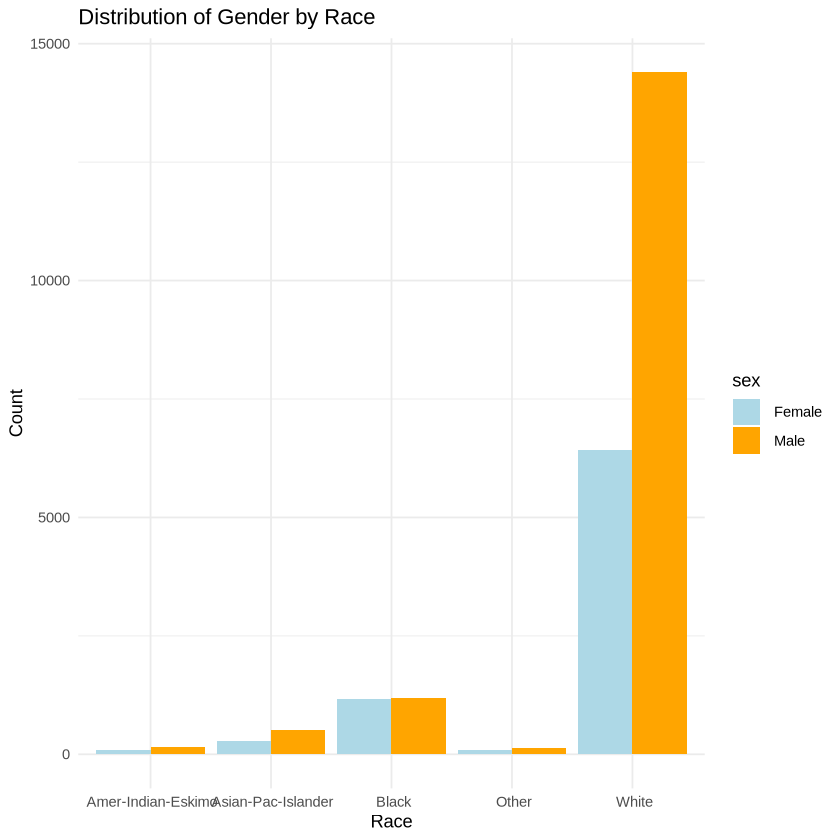

In [39]:
# Create a bar plot
gener_by_race_plot <- ggplot(adult_training, aes(x = race, fill = sex)) +
  geom_bar(position = "dodge", stat = "count") +
  labs(title = "Distribution of Gender by Race",
       x = "Race",
       y = "Count") +
  scale_fill_manual(values = c("lightblue", "orange")) +
  theme_minimal()

gener_by_race_plot